In [21]:
import os
import scipy.io as sio 
import numpy as np
from scipy.signal import cspline1d, cspline1d_eval

from operator import itemgetter

%matplotlib inline 
import matplotlib.pyplot as plt

import numpy as np
from scipy.signal import medfilt

from scipy.signal import resample
from scipy.interpolate import interp1d

from scipy.linalg import svd
from scipy import signal

In [22]:
def ResampleLinear1D(original, targetLen):
    original = np.array(original, dtype=np.float)
    index_arr = np.linspace(0, len(original)-1, num=targetLen, dtype=np.float)
    index_floor = np.array(index_arr, dtype=np.int) #Round down
    index_ceil = index_floor + 1
    index_rem = index_arr - index_floor #Remain

    val1 = original[index_floor]
    val2 = original[index_ceil % len(original)]
    interp = val1 * (1.0-index_rem) + val2 * index_rem
    assert(len(interp) == targetLen)
    return interp

In [10]:
def smooth_part(x,window_len,window):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise (ValueError, "smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise (ValueError, "Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise (ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y


def smooth(x, time, thr=5, w=11, w_t='hanning'):
    steps = [0]
    for i in range(x.shape[0]-1):
        if abs(x[i] - x[i+1]) > 5:
            steps.append(i)
            steps.append(i+1)
    steps.append(len(x)-1)

    steps_n = []
    for i in range(0,len(steps), 2):
        if (steps[i+1] - steps[i]) > w:
            steps_n.append(steps[i])
            steps_n.append(steps[i+1])

    denoised_x = []
    x_n = []
    time_n = []
    for i in range(0, len(steps_n), 2):
        denoised_part = smooth_part(x[steps_n[i]: steps_n[i+1]], window_len=w, window=w_t)[w//2:-1 * w//2 + 1]
        denoised_x += list(denoised_part)
        x_n += list(x[steps_n[i]: steps_n[i+1]])
        time_n += list(time[steps_n[i]: steps_n[i+1]])
        
    print (len(time_n), len(x_n), len(denoised_x))

    return x_n, denoised_x, time_n

In [11]:
DATA_PATH = '../../../datasets/data/train_raw/'

data_lm10             = sio.loadmat(os.path.join(DATA_PATH, 'LM10.mat'))
data_lm20_torquesteps = sio.loadmat(os.path.join(DATA_PATH.replace('train', 'test'), 'LM20_TorqueSteps.mat'))
data_lm30             = sio.loadmat(os.path.join(DATA_PATH.replace('train', 'test'), 'LM30.mat'))
data_lm45_torquesteps = sio.loadmat(os.path.join(DATA_PATH, 'LM45_TorqueSteps.mat'))
data_lm50             = sio.loadmat(os.path.join(DATA_PATH, 'LM50.mat'))
data_lm60_torquesteps = sio.loadmat(os.path.join(DATA_PATH.replace('train', 'test'), 'LM60_TroqueSteps.mat'))
data_lm68             = sio.loadmat(os.path.join(DATA_PATH, 'LM68.mat'))
data_spdvar           = sio.loadmat(os.path.join(DATA_PATH, 'NoLM_SpeedVariations.mat'))
data_spdvar2          = sio.loadmat(os.path.join(DATA_PATH.replace('train', 'test'), 'NoLM_SpeedVariations2.mat'))

In [12]:
data_lm10.keys()

dict_keys(['__header__', '__version__', '__globals__', 'voltage_d', 'voltage_q', 'speed', 'current_d', 'current_q', 'torque', 'time'])

In [13]:
def plot_ts(data):
    plt.plot(data['time'][0], data['torque'][0])
    plt.show()
    plt.plot(data['time'][0], data['speed'][0])
    plt.show()

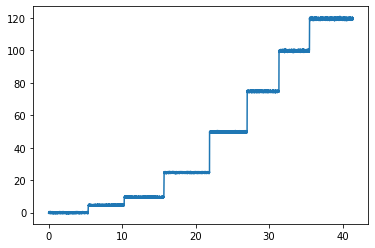

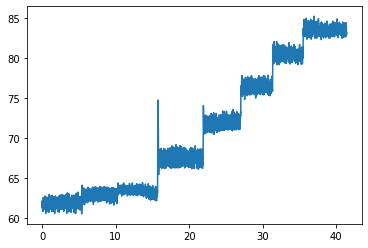

In [14]:
plot_ts(data_lm10)

In [35]:
def denoise_data(data):
    w = 101
    w_t = "hamming"
    speed, denoised_speed, time_s = smooth(data['speed'][0], data['time'][0], 1, w=w, w_t=w_t)
    torque, denoised_torque, time_t = smooth(data['torque'][0], data['time'][0], 5, w=w, w_t=w_t)    
    plt.plot(time_s, denoised_speed)
    plt.show()
    plt.plot(time_t, denoised_torque)
    plt.show()
    
    speed_down = ResampleLinear1D(np.asarray(denoised_speed), data['time'].shape[1])
    torque_down = ResampleLinear1D(np.asarray(denoised_torque), data['time'].shape[1])
    speed = ResampleLinear1D(np.asarray(speed), data['time'].shape[1])
    torque = ResampleLinear1D(np.asarray(torque), data['time'].shape[1])
    
    return {'dspeed':speed, 'dtorque':torque, 'cspeed': speed_down, 'ctorque': torque_down,
            'dcurrent_d': data['current_d'][0], 'dcurrent_q': data['current_q'][0], 'dvoltage_d': data['voltage_d'][0],
           'dvoltgage_q': data['voltage_q'][0], 'time': data['time'][0]}

10295 10295 10295
7160 7160 7160


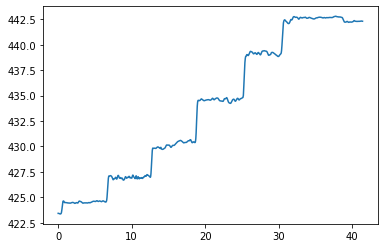

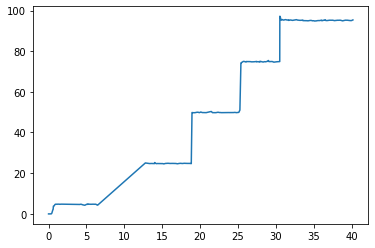

50808 50808 50808
38789 38789 38789


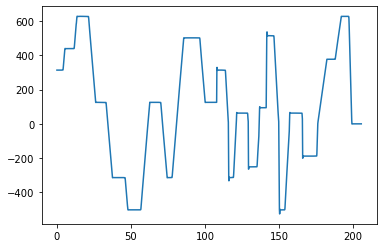

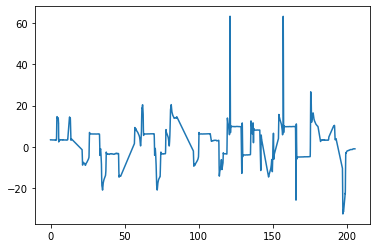

39892 39892 39892
30262 30262 30262


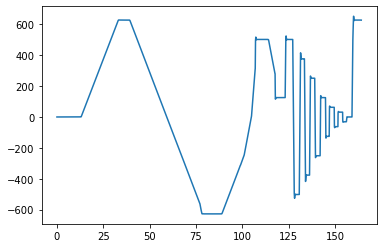

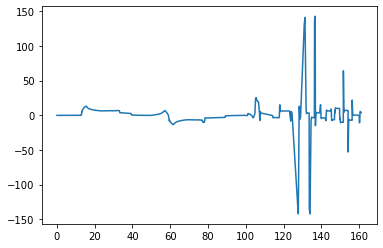

In [39]:
RES_PATH = './'
cdata_lm10             = denoise_data(data_lm10)
sio.savemat(os.path.join(RES_PATH, 'LM10.mat'), cdata_lm10)

cdata_lm20_torquesteps = denoise_data(data_lm20_torquesteps)
sio.savemat(os.path.join(RES_PATH, 'LM20_TorqueSteps.mat'), cdata_lm20_torquesteps)

cdata_lm30             = denoise_data(data_lm30)
sio.savemat(os.path.join(RES_PATH, 'LM30.mat'), cdata_lm30)


cdata_lm45_torquesteps = denoise_data(data_lm45_torquesteps)
sio.savemat(os.path.join(RES_PATH, 'LM45_TorqueSteps.mat'), cdata_lm45_torquesteps)

cdata_lm50             = denoise_data(data_lm50)
sio.savemat(os.path.join(RES_PATH, 'LM50.mat'), cdata_lm50)

cdata_lm60_torquesteps = denoise_data(data_lm60_torquesteps)
sio.savemat(os.path.join(RES_PATH, 'LM60_TorqueSteps.mat'), cdata_lm60_torquesteps)

cdata_lm68             = denoise_data(data_lm68)
sio.savemat(os.path.join(RES_PATH, 'LM68.mat'), cdata_lm68)

cdata_spdvar           = denoise_data(data_spdvar)
sio.savemat(os.path.join(RES_PATH, 'NoLM_SpeedVariations.mat'), cdata_spdvar)

cdata_spdvar2          = denoise_data(data_spdvar2)
sio.savemat(os.path.join(RES_PATH, 'NoLM_SpeedVariations2.mat'), cdata_spdvar2)

In [106]:
print (data['speed'][0].shape)

NameError: name 'data' is not defined